# Performance Metrics for Binary Classification Problems

In [7]:
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random

import sklearn
from sklearn import *

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

import graphviz
import xgboost
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,export_graphviz
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix

# For imbalanced learning
import imblearn

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

## Threshold Based Metrics

Binary classification problems are problems by which you are trying to train a model to recognize a data point as one thing or the other-as 1 or 0. Fraud dection is usually considered a binary classification issue. For this issue, a system recieves transactions and is given the goal to predict whether or not a transaction is likely to be geniune or fraudulent. Usually a system returns a fraud score and after, a set of transactions only need to be ordered. The higher the value, the higher the likelihood(or probability) of fraud. 
Lets assume the probability p(x) for a transaction x to be fraud, is a value between 0 and 1. The decision to classify a transaction as fraudulent can then be made by setting a threshold 0<=t<=1 on the probability p(x), so that way if p(x)>t, then the transaction is classified as fraudulent, or genuine if p(x)<t. 
Yet how do we get the threshold(s)?
How do we determine our thresholds are optimal enough for our model?
Answer's to answered later

### Confusion Matrix

Once we choose our threshold, we'll have to determine whether or not this threshold is even good enough for our binary classification problem. This is where our Confusion Matrix comes in. The outcome of a binary classification problem is usually reprented as a confusion matrix.

1. Y1 is the set of positive instances 
2. Y0 is the set of negative ones 
3. Y1hat is the set of transactions *predicted* as positive
4. Y0hat is the set of transactions *predicted* as negative

In [13]:
Image(url="confusion.png", width=300, height=300)

There are 4 possible outcomes:
1. TP: True positives. Instances of 1(frauds) that the classifier predicts as fraudulent 
2. TN: True negatives. These are the instances of class 0(genuine transactions), that the classifier correctly predicts as frauds 
3. FP: False positives. Class 0(genuine transactions) that the classifier incorrectly predicts as frauds 
4. FN: False negatives. Class 1(frauds) that the classifier incorrectly predicts as genuine transactions 

### Mean Classification

The simplest and way that makes the most sense in seeing if a binary classifier is good is to compute the proportion of misclassified instances (False negatives and false positives). This is known as the mean classification error (MME)

                                                                                                    MME = FP + FN/ N
                            
                                                                                                 N = TN + TP + FN + FP
Accuracy = 1-MME = TP + TN/N: Measures for the set of transactions that are classified correctly
                                          
Precision = TP /TP + FP: Measures for the set of transactions that are predicted as fraudulent, the proportion of transactions that are indeed fraudulent
                                            
Recall(TPR) = TP/ TP + FN: Measures the Proportion of negatives that are correctly identified 
                                            
F1 Score = 2 * (Precision * Recall/ Precision + Recall): Total measure of precision and recall, which can only be computed once a confusion matrix is available (only when threshold t is used for classification)
                               
Specificity(TNR) = TN/ FP + TN: Measures the proportion of negatives that are correctly identified

In [8]:
# Implementation of the mean misclassification error
def compute_MME(true_labels,predicted_classes):
    
    N = len(true_labels)
    
    MME = np.sum(np.array(true_labels)!=np.array(predicted_classes))/N
    
    return MME

In [9]:
thresholds=[1,0.5,0.3]

Lets test this out with an example

In [10]:
# 3 fraudulent and 9 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

In [11]:
#lets dry to turn this into a function later on
tx = pd.DataFrame(
    {'label': true_labels,
     'f_probrabilities': fraud_probabilities,
    })
tx

,label,f_probrabilities
0,1,0.90
1,1,0.35
2,0,0.45
3,0,0.40
4,0,0.20
5,0,0.20
6,0,0.20
7,0,0.10
8,0,0.10
9,0,0.00


Now lets create 3 thresholds:
1. t =1: This will clasify all transacions as genuine
2. t =0.5: This is usually considered the default threshold and assumes a transaction with a fraud prob higher than 0.5 will be classified as fraud 
3. t =0.3: This will most likely allow is to correctly allow us to correctly classify the 2 fraudulant transactions

Lets plot the confusion matrix plots. And lets make sure to keep these important aspects in mind:
There are 4 possible outcomes for our matrix:
1. TP: True positives. Instances of 1(frauds) that the classifier predicts as fraudulent 
2. TN: True negatives. These are the instances of class 0(genuine transactions), that the classifier correctly predicts as frauds 
3. FP: False positives. Class 0(genuine transactions) that the classifier incorrectly predicts as frauds 
4. FN: False negatives. Class 1(frauds) that the classifier incorrectly predicts as genuine transactions 

In [12]:
def get_class_from_fraud_probability(fraud_probabilities, threshold=0.5):
    
    predicted_classes = [0 if fraud_probability<threshold else 1 
                         for fraud_probability in fraud_probabilities]

    return predicted_classes

#### Confusion Matrix for the threshold of 1

In [80]:
threshold=1
predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold)
print('Print Predicted Class:',predicted_classes)

MME = compute_MME(true_labels,predicted_classes)
print('MME:',MME)

cf_matrix = confusion_matrix(true_labels, predicted_classes)
print('matrix:', cf_matrix)

Print Predicted Class: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MME: 0.2
matrix: [[8 0]
 [2 0]]


<AxesSubplot:>

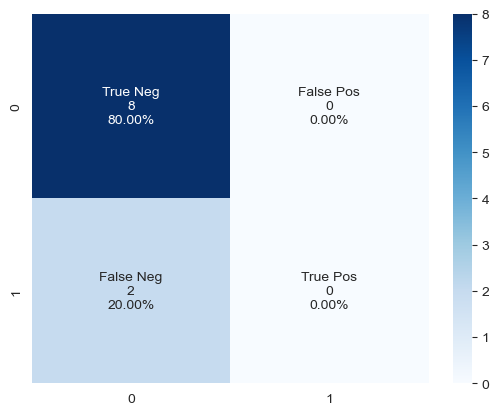

In [81]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

With a treshold of t=1, all transactions are predicted as genuine and this classifier makes two mistakes by classifyingg the 2 fraudulent transactions as genuine. As a result this predicter is a little useless to us. The reason why its even able to correctly classify the genuine transactions is due to the fact that the data we have is so imbalanced. 

#### Confusion Matrix for the threshold of 0.5

In [82]:
threshold=0.5
predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold)
print('Print Predicted Class:',predicted_classes)

MME = compute_MME(true_labels,predicted_classes)
print('MME:',MME)

cf_matrix = confusion_matrix(true_labels, predicted_classes)
print('matrix:', cf_matrix)

Print Predicted Class: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
MME: 0.1
matrix: [[8 0]
 [1 1]]


<AxesSubplot:>

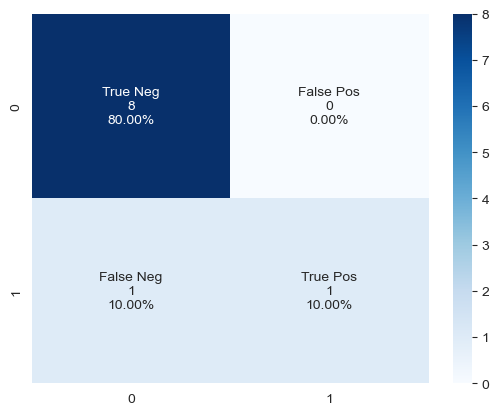

In [83]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

With this threshold of 0.5 we can see that our classifier is performing better since it only misclassifies only 1 fraudulent transaction. The class imbalance is still effecting it, yet we are getting better

#### Confusion Matrix for the threshold of 0.3

In [84]:
threshold=0.3
predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold)
print('Print Predicted Class:',predicted_classes)

MME = compute_MME(true_labels,predicted_classes)
print('MME:',MME)

cf_matrix = confusion_matrix(true_labels, predicted_classes)
print('matrix:', cf_matrix)

Print Predicted Class: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
MME: 0.2
matrix: [[6 2]
 [0 2]]


<AxesSubplot:>

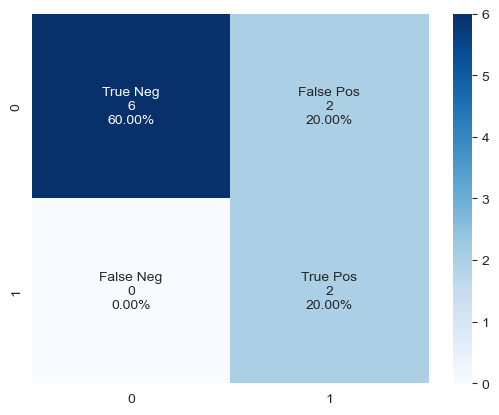

In [85]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Now with this threshold of 0.3, we can see that all of our fraudulent transactions are correctly classified as fraudulent with 2 True Positives, but we also that our classifier has incorrectly classified 2 genuine transactions as fraudulent. Better than our last 2 thresholds yet it is still not optimal.

This exercise shows the shortcomings of the MME: it gives the same weight to false negatives and false positives. Our 3rd classifier would work best if we are trully trying to detect fraudulent transactions and find that paramount but the MME is not best when used on its own. Another helpful add to the MME is the Cost Matrix, which would be a matrix that gives a parameter for each variable of TN, FN, TP, FP. This would give us a weightloss function by multiplying each entry of the confusion matrix with the corresponding entry in the cost matrix.
                                                                  
                                                                                             WL = TNxC0 + FNxC01 + FPxC10 + TPxC11/ N
                                                                  
The idea would be to give a misclassification error for FP an FN a high cost, probably a cost equal to the fraudulent transaction since that is the cost to the business when the misclassify fraudulent transactions as genuine and vice versa. The overall cost should also include the time taken by the detection system to react. These parameters are very hard to set, yet they do elevate the use of the MME. There are other Performance Metrics that are derived from the confusion matrix that are helpful in helping us decide our models performance. 

### Other Performance Metrics

MME = FP + FN/ N
                            
                                                                                                 N = TN + TP + FN + FP
Accuracy = 1-MME = TP + TN/N: Measures for the set of transactions that are classified correctly
                                          
Precision = TP /TP + FP: Measures for the set of transactions that are predicted as fraudulent, the proportion of transactions that are indeed fraudulent
                                            
Recall(TPR) = TP/ TP + FN: Measures the Proportion of negatives that are correctly identified 
                                            
F1 Score = 2 x (Precision x  Recall/ Precision + Recall): Total measure of precision and recall, which can only be computed once a confusion matrix is available (only when threshold t is used for classification)
                               
Specificity(TNR) = TN/ FP + TN: Measures the proportion of negatives that are correctly identified

BER(Balanced Error Rate) = 0.5x(FNR+FPR) FNR being the false negative rate and FPR being the false positive rate: This provides a balance measure of accuracy. BER is a weighted liss wehere the misclassification costs make up for the class imbalance. 

G-Mean = squareroot(TPRxTNR): An alternative measure to BER that aggregates the TNR(True negative rate) and the TPR(True positive rate). Has an inverse relationship with the BER

Lets take a look at some of these metrics for our example 

In [21]:
def threshold_based_metrics(fraud_probabilities, true_label, thresholds_list):
    
    results = []
    
    for threshold in thresholds_list:
    
        predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    
        (TN, FP, FN, TP) = metrics.confusion_matrix(true_label, predicted_classes).ravel()
    
        MME = (FP+FN)/(TN+FP+FN+TP)
    
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP)
    
        FPR = FP/(TN+FP)
        FNR = FN/(TP+FN)
        
        BER = 1/2*(FPR+FNR)
        
        Gmean = np.sqrt(TPR*TNR)
    
        precision = 0
        FDR = 0
        F1_score=0
        
        if TP+FP>0:
            precision = TP/(TP+FP)
            FDR=FP/(TP+FP)
        
        NPV = 0
        FOR = 0
        
        if TN+FN>0:
            NPV = TN/(TN+FN)
            FOR = FN/(TN+FN)
            
        
        if precision+TPR>0:
            F1_score = 2*(precision*TPR)/(precision+TPR)
    
        results.append([threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score])
        
    results_df = pd.DataFrame(results,columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    
    return results_df

In [22]:
unique_thresholds = list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)
unique_thresholds

[0.9, 0.45, 0.4, 0.35, 0.2, 0.1, 0]

In [24]:
results_df = threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
results_df

,Threshold,MME,TPR,TNR,FPR,FNR,BER,G-mean,Precision,NPV,FDR,FOR,F1 Score
0,0.90,0.1,0.5,1.000,0.000,0.5,0.2500,0.707107,1.000000,0.888889,0.000000,0.111111,0.666667
1,0.45,0.2,0.5,0.875,0.125,0.5,0.3125,0.661438,0.500000,0.875000,0.500000,0.125000,0.500000
2,0.40,0.3,0.5,0.750,0.250,0.5,0.3750,0.612372,0.333333,0.857143,0.666667,0.142857,0.400000
3,0.35,0.2,1.0,0.750,0.250,0.0,0.1250,0.866025,0.500000,1.000000,0.500000,0.000000,0.666667
4,0.20,0.5,1.0,0.375,0.625,0.0,0.3125,0.612372,0.285714,1.000000,0.714286,0.000000,0.444444
5,0.10,0.7,1.0,0.125,0.875,0.0,0.4375,0.353553,0.222222,1.000000,0.777778,0.000000,0.363636
6,0.00,0.8,1.0,0.000,1.000,0.0,0.5000,0.000000,0.200000,0.000000,0.800000,0.000000,0.333333


Looking at our table we can see that our threshold of 0.35 is what minimizes our BER and maximizes the G-mean and F1 score. This would be a sensible choice for this example but if the problem is required to maximize precision, a threshold of 0.9 should be selected instead. 
Overall, the main benefit of threshold based metrics is to provide a detailed view of the misclassification errors, but due to their dependence on the threshold t, they make the comparison of classifiers difficult. When the application constraints and the objective are very clearly defined, these metrics can be useful, but if not, it may be better to perform more generalized comparisons with threshold-free metrics. 

## Threshold Free Metrics

### ROC Curve - Receiving Operating Charateristic (ROC) Curve

This is a curve that is obtained by plotting the TPR(True Positive Rate) against the False Positive Rate(FPR) for all the different classification thresholds t. Its the most well known and most used standard for estimating the performance of fraud detection and binary classifications in the literature. Lets take a look at how it is is constructed with an example. 

In [ ]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

The first step in computing the ROC curve is getting  all the uniqe possible thresholds for which the TPR(True Positive Rate) and FPR(False Positive Rate) will be computed and sort them out by decreasing order

In [25]:
unique_thresholds = [1.1]+list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)
unique_thresholds

[1.1, 0.9, 0.45, 0.4, 0.35, 0.2, 0.1, 0]

In [26]:
performance_metrics=threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
performance_metrics[['Threshold','TPR','FPR']]

,Threshold,TPR,FPR
0,1.10,0.0,0.000
1,0.90,0.5,0.000
2,0.45,0.5,0.125
3,0.40,0.5,0.250
4,0.35,1.0,0.250
5,0.20,1.0,0.625
6,0.10,1.0,0.875
7,0.00,1.0,1.000


As we can see the lower the threshold, the higher the likelihood of fraud being detected (We can see the FPR decreasing and the TPR increasing as the t rate lowers). 0.35 would be ideal as it has the lowest FPR as well as a high TPR

Now lets use the ROC curve function in sklearn.metrics ot compute the thresholds as well as their corresponding FPR and TPR rates

In [27]:
FPR_list, TPR_list, threshold = sklearn.metrics.roc_curve(true_labels, fraud_probabilities, drop_intermediate=False)
FPR_list, TPR_list, threshold

(array([0.   , 0.   , 0.125, 0.25 , 0.25 , 0.625, 0.875, 1.   ]),
 array([0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. ]),
 array([1.9 , 0.9 , 0.45, 0.4 , 0.35, 0.2 , 0.1 , 0.  ]))

In [ ]:
%%capture
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")

ROC_AUC = metrics.auc(FPR_list, TPR_list)    
    
roc_curve, ax = plt.subplots(figsize=(5,5))
get_template_roc_curve(ax, "Receiver Operating Characteristic (ROC) Curve",fs=15)
ax.plot(FPR_list, TPR_list, 'b', color='blue', label = 'AUC ROC Classifier = {0:0.3f}'.format(ROC_AUC))
ax.legend(loc = 'lower right')

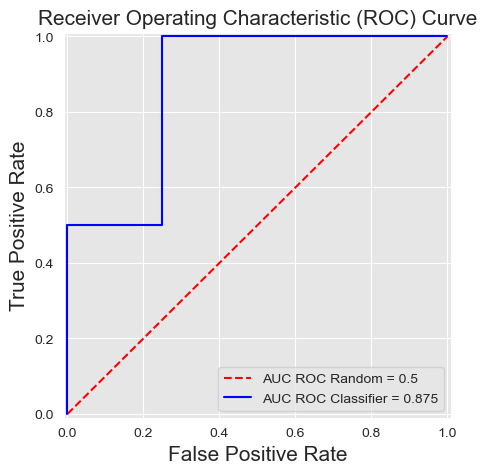

In [29]:
roc_curve

The ROC Curve has 3 important properties:
1. First, they are monotonic functions: The TPR can only increase as the FPR increases. 
2. the area under the curve has a probabilistic interpretation: The AUC ROC can be interpreted as the probability that the scores given by a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. Third, the AUC ROC of a random classifier is 0.5
3. Third, the AUC ROC of a random classifier is 0.5

This is a good way to get a sense of a classifiers performance over the whole range of possible FPR, but this curve and metric alone can be inadequate for imbalanced problems. Lets take a look at another Threshold free performance metric. 

### Precision-Recall curve

This curve is obtained by plotting the precision against the recall(TPR-True Positive Rate) for all the different classification thresholds t. This is a well liked tool since it allows us to optimize for classifiers that can both a high recall (TPR) and a high precision(a strong inverse relationship between a high TPR and a low FPR)

We'll use the same example we've been using throughout to illustrate this and plot our PR Curve. 

In [31]:
# 2 fraudulent and 8 genuine transactions
true_labels = [1,1,0,0,0,0,0,0,0,0]

# Probability of fraud for each transaction
fraud_probabilities = [0.9,0.35,0.45,0.4,0.2,0.2,0.2,0.1,0.1,0]

unique_thresholds = [1.1]+list(set(fraud_probabilities))
unique_thresholds.sort(reverse=True)

performance_metrics=threshold_based_metrics(fraud_probabilities, true_labels, unique_thresholds)
performance_metrics[['Threshold','Precision','TPR']]

,Threshold,Precision,TPR
0,1.10,0.000000,0.0
1,0.90,1.000000,0.5
2,0.45,0.500000,0.5
3,0.40,0.333333,0.5
4,0.35,0.500000,1.0
5,0.20,0.285714,1.0
6,0.10,0.222222,1.0
7,0.00,0.200000,1.0


In [ ]:
Lets us Average Precision which is the weighted mean of precisions obtained at each threshold multiplied by the increase in recall from the previous threshold. 

In [32]:
def compute_AP(precision, recall):
    
    AP = 0
    
    n_thresholds = len(precision)
    
    for i in range(1, n_thresholds):
        
        if recall[i]-recall[i-1]>=0:
            
            AP = AP+(recall[i]-recall[i-1])*precision[i]
        
    return AP

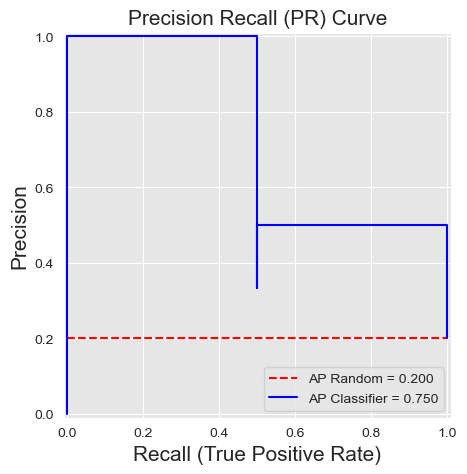

In [33]:
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = {0:0.3f}'.format(baseline))

precision = performance_metrics.Precision.values
recall = performance_metrics.TPR.values
    
pr_curve, ax = plt.subplots(figsize=(5,5))
get_template_pr_curve(ax, "Precision Recall (PR) Curve",fs=15,baseline=sum(true_labels)/len(true_labels))
AP2 = metrics.average_precision_score(true_labels, fraud_probabilities)
AP = compute_AP(precision, recall)
ax.step(recall, precision, 'b', color='blue', label = 'AP Classifier = {0:0.3f}'.format(AP))
ax.legend(loc = 'lower right')

The PR curves behave differently from ROC curves in the following ways:
1. Not monotonic(don't follow a strict inverse relationship). The precicion may decrease or increase as recall increases) We can see that for a recall of 0.5, the precision first goes down to 0.3 or so then goes up again to about 0.5. These are for thresholds of 0.4 and 0.35 respectively. 
2. Their AUC does not carry a statistical interpretation as ROC AUC.
3. The performance of a random classifier depends on the class imbalance. When our dataset is balanced it should be 0.5 (p/(p+n)). In this case it gives us a Random classifier of 0.2 since our precision 2/(2+8) is 0.2. It better reflects the issue of class imbalance in the data set. The AP of a random classifier will decrease as the class imbalance ratio increases)

### Precision top-k metrics¶

Precision top-k metrics aim at quantifying the performance of a Fraud Detection System in the real world. With this metric we are working with the assumption that fraud investigators will be checking for frauds on a daily basis. The k parameter quantifies the maximum number of alerts that can be checked by investigators in a day.

Say we set a precision top k of 100, this will work of the assumption that we think investigators can check about 100 fraud transactions per day. If we get a precision of 0.40, that would indicate that out of the 100 most suspiciously high transactions, 26 of them were truly fraudulent